### Import Libraries

In [5]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

### Load Data

In [6]:
groundtruth_dir = 'Data/clean_data/'  
groundtruth_data = []


for file_name in os.listdir(groundtruth_dir):
    if file_name.endswith('.json'):
        with open(os.path.join(groundtruth_dir, file_name), 'r') as file:
            for line in file:
                try:
                    entry = json.loads(line)
                    # Extract trip_id and time (ground truth)
                    groundtruth_data.append({
                        'trip_id': entry['trip_id'],
                        'actual_eta': entry['time']  
                    })
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON in {file_name}: {e}")


groundtruth_df = pd.DataFrame(groundtruth_data)

In [7]:
# Load RFR and XGBoost prediction files
rfr_predictions = pd.read_csv('Model Predictions/rfr_predictions.csv')  
xgb_predictions = pd.read_csv('Model Predictions/xgboost_predictions.csv')  

xgb_predictions.rename(columns={'predicted_eta': 'xgb_time'}, inplace=True)

if 'segment_id' in rfr_predictions.columns:
    rfr_pivot = rfr_predictions.pivot_table(index='trip_id', columns='segment_id', values='predicted_eta').reset_index()

    # Rename columns for each trip segment
    rfr_pivot.columns = ['trip_id', 'rfr_time_1', 'rfr_time_3']
else:
    raise KeyError("'segment_id' column not found in rfr_predictions. Ensure it exists.")

# Merge the RFR and XGBoost predictions with ground truth data
combined_df = (
    pd.merge(rfr_pivot, xgb_predictions[['trip_id', 'xgb_time']], on='trip_id', how='inner')
    .merge(groundtruth_df, on='trip_id', how='inner')
)

combined_df['total_predicted_eta'] = combined_df['rfr_time_1'] + combined_df['rfr_time_3'] + combined_df['xgb_time']

In [8]:
combined_df.isnull().sum()

trip_id                   0
rfr_time_1             2413
rfr_time_3               34
xgb_time                  0
actual_eta                0
total_predicted_eta    2447
dtype: int64

In [9]:
# drop rows where rfr_time_3 is null
combined_df = combined_df.dropna(subset=['rfr_time_3'])

In [10]:
# fill missing values (segment 1) with the 0 
combined_df = combined_df.fillna(0)

### Modeling

In [11]:
X = combined_df[['rfr_time_1', 'rfr_time_3', 'xgb_time']]  
y = combined_df['actual_eta']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Meta-model training
meta_model = LinearRegression()
meta_model.fit(X_train, y_train)

y_pred = meta_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Meta-Model Metrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}\n")

# Save the combined results with predicted ETA to a CSV file
combined_df['final_predicted_eta'] = meta_model.predict(X)
combined_df.to_csv('Model Predictions/final_predictions.csv', index=False)
print("Stacked ETA predictions saved to 'meta_predictions.csv\n")

print(combined_df.head())

Meta-Model Metrics:
RMSE: 335.73160642222365
MAE: 256.82727407844243
R² Score: 0.7282188676474799

Stacked ETA predictions saved to 'meta_predictions.csv

                                             trip_id  rfr_time_1   rfr_time_3  \
0  00035b05d1d9853649aee8e61cd4739d34081a3da332ec...  221.147383   365.806606   
1  0005758f5a026edab89e6ff5e8c5b23f083d70bf7847c3...  387.468525   787.671406   
2  0007ca27a8887c6c4b3a4fd3db733f20f509fca465571c...    0.000000  1163.013926   
3  000875dad0cfe307ce5f1e2c000ab58ea3c95db15314bf...  144.474385   721.106135   
4  00107faefd34084c4ed4f477151f344cd65db0e04bd889...  129.427563   925.410898   

    xgb_time  actual_eta  total_predicted_eta  final_predicted_eta  
0  346.70334      1047.0           933.657329          1009.453528  
1  626.53670      2121.0          1801.676631          1874.148243  
2  449.51437      1952.0             0.000000          1757.973550  
3  407.58182      1030.0          1273.162340          1375.994263  
4  469.47784 

### Feature Importance

Feature Importance for Linear Regression Model:
      feature  coefficient
2    xgb_time     1.382629
1  rfr_time_3     0.914237
0  rfr_time_1     0.553776


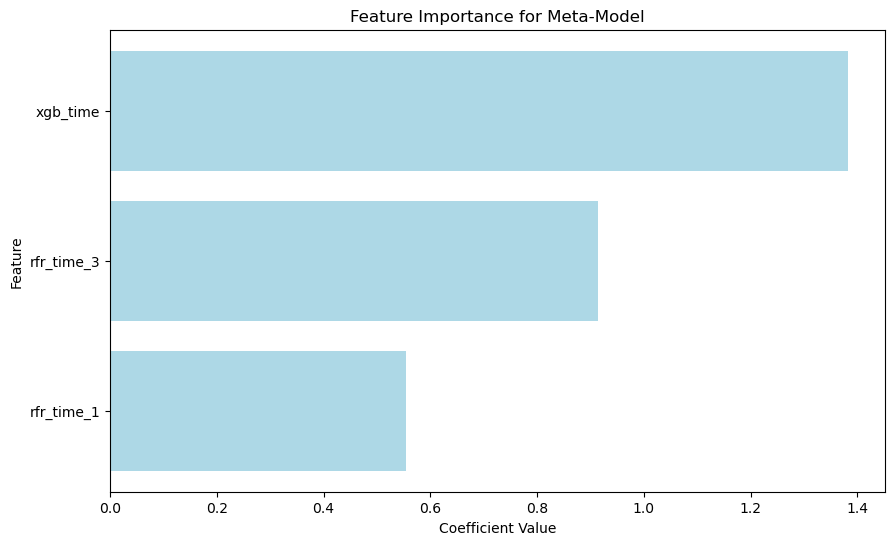

In [13]:
# Get the feature coefficients from the trained meta-model
coefficients = meta_model.coef_


feature_importance_df = pd.DataFrame({
    'feature': X.columns,  
    'coefficient': coefficients
})

# Sort by the absolute value of coefficients for better interpretation
feature_importance_df['abs_coefficient'] = np.abs(feature_importance_df['coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='abs_coefficient', ascending=False)

# Display the feature importance
print("Feature Importance for Linear Regression Model:")
print(feature_importance_df[['feature', 'coefficient']])


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Meta-Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()
